In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import dlc_practical_prologue2 as prologue

print('libraries imported')

libraries imported


To get the data for the first project, we are using one of the functions of *dlc_practical_prologe.py* that randomly generates one for us given a size parameter. It returns a tuple containing the: *training set, targets, classes* and *testing set, targets, classes*. 

In [2]:
sample_size = 1000
sets = prologue.generate_pair_sets(sample_size)

train_set = sets[0]
train_target = sets[1]
train_classes = sets[2]

test_set = sets[3]
test_target = sets[4]
test_classes = sets[5]

The inputs are grayscale MNIST images consisting of two channels ($2 \times 14 \times 14$) representing two different digits. As visualized below, target vector contains the index of the channels which have the highest digit between the two (channel $0$ or $1$). 

Therefore, our task is to maximize the prediction of this boolean value.

For the first training data point with two channels, target is 0


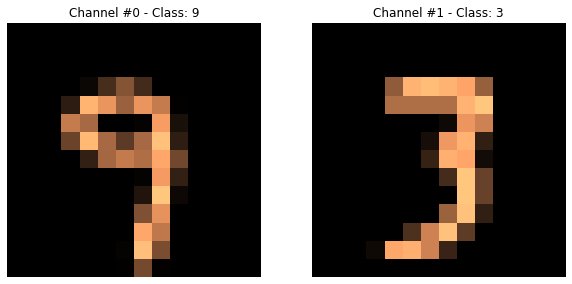

In [3]:
print('For the first training data point with two channels, target is {}'.format(train_target[0]))
fig1, axes = plt.subplots(1, 2, figsize = (10, 7))
ax = axes.ravel()

for i in range(len(ax)):
    ax[i].set_title('Channel #{} - Class: {}'.format(i, train_classes[0][i]))
    ax[i].imshow(train_set[0][i], cmap='copper')
    ax[i].axis('off')
plt.show()

Function to train the model by moving it through the given mini batch size and using Adam as an optimizer.

In [4]:
def train_model(n_epochs, eta, loss_criterion, model, train_input, train_target, mini_batch_size):
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.01, lr = eta)
    for _ in range(n_epochs):
        acc_loss = 0 ## set error as 0 each iteration
        ## Using mini-batches
        for b in range(0, train_input.size(0), mini_batch_size): 
            output = model(train_input.narrow(0, b, mini_batch_size))
            # print('Loss Shapes: Output: {}, Target: {}'.format(output.shape, train_target.narrow(0, b, mini_batch_size).shape))
            loss = loss_criterion(output, train_target.narrow(0, b, mini_batch_size).float())
            acc_loss = acc_loss + loss.item()

            model.zero_grad() ## setting the gradients to zero before the loss calculation
            loss.backward()
            optimizer.step()                    
    # print('Final Output: ', output, output.shape)
    # print(torch.argmax(output, dim=1))
    print('Model Training Finished - Final loss after {} epochs: {}'.format(n_epochs, acc_loss))

Round the final values outputted from the network into binary values and compare them with the target binary matrix in order to get the number of errors.

The sigmoid function $\sigma(x) = \frac 1 {1+exp(-x)}$ is applied to the output to distribute the output values between $0$ and $1$, after which a rounding process happens to finally compare them with our binary targets. 

In [5]:
def compute_nb_errors(model, input, target, mini_batch_size):
    nb_errors = 0
    with torch.no_grad():
        for b in range(0, input.size(0), mini_batch_size):
            output = torch.sigmoid(model(input.narrow(0, b, mini_batch_size)))
            errors = torch.where(torch.round(output) != target.narrow(0, b, mini_batch_size))

            ## Errors return a tuple with the first element being a tensor with indexes
            ## Where the targets and predictions dont match
            ## Therefore we get the size of this tensor as a number of errors
            nb_errors += errors[0].size(0) 
    return nb_errors

##### Defining both models

The first model will be a classical Binary Convolutional Network Classifier inspired by LeNet, that takes the number of the hidden layers of the final fully connected layer as a parameter. 
As seen from the results below, it suffers from overfitting at the moment therefore it should be modified (dropout to be added next).

The second model will be a Multi-Layer Perceptron with only linear hidden layers, constructed in order to compare the difference between this and the convolutional network, measuring the overfitting too. 

They both includes multiple dropout layers with respective rates of $0.4$ and share a weight decay parameter on the Adam Optimizer, as measures to combat overfitting.

In [6]:
class MLP(nn.Module):
    def __init__(self, dropout_rate): ## defining the layers
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.flatten_dim_0 = nn.Flatten(0)
        self.flatten_dim_1 = nn.Flatten(1)
        
        self.layers = nn.Sequential(
            nn.Linear(2 * 14 * 14, 1024),
            nn.ReLU(inplace = True),
            nn.Linear(1024, 512),
            nn.Dropout1d(0.0),
            nn.ReLU(inplace = True),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.Dropout1d(0.0),
            nn.ReLU(inplace = True),
            nn.BatchNorm1d(256),
            nn.Linear(256, 1) ## output layer
        )

        # Fully Connected Layers        
        self.fc1 = nn.Linear(2 * 14 * 14, 1024) ## (2x14x14) images
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1) ## output layers

        
    ## Generally, strides for convolution layers are 1 and for maxpools are 2
    ## Uncomment the prints for debugging
    def forward(self, x): 
        x = self.flatten_dim_1(x)
        # print('Flattened Input Shape: ', x.shape)
        x = F.relu(self.fc1(x))
        # print('First FC Layer Shape', x.shape)
        x = F.relu(self.dropout(self.fc2(x)))
        x = self.batchnorm1(x)
        # print('Second FC Layer Shape', x.shape)
        x = F.relu(self.dropout(self.fc3(x)))
        x = self.batchnorm2(x)
        # print('Third FC Layer Shape', x.shape)
        x = self.fc4(x)
        x = self.flatten_dim_0(x)
        # print('Final Output Shape {} \n'.format(x.shape))
        return x

Binary Convolutional Neural Network

In [120]:
class BinaryCNN(nn.Module):
    def __init__(self, hidden_layer_n, dropout_rate): ## defining the layers
        super().__init__()
        self.dropoutfc = nn.Dropout(p = 0.0)
        self.dropoutcnn = nn.Dropout(p = 0.15)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.flatten0 = nn.Flatten(0)
        self.flatten1 = nn.Flatten(1)
                
        ### We need to convert to a sequential after we have a stable model
        # self.features = nn.Sequential()
        
        # Feature Extractors & Data Normalizers 
        self.conv1 = nn.Conv2d(2, 64, kernel_size = 3, stride = 1)
        self.conv1_bn = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1)
        self.conv2_bn = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_bn = nn.BatchNorm2d(256)
        # self.conv4 = nn.Conv2d(96, 128, kernel_size = 3, stride = 1, padding = 1)
        # self.batchnorm4 = nn.BatchNorm2d(128)

        
        # Classifiers & Output Layers
        self.fc1 = nn.Linear(256, 1)
        # self.fc1_bn = nn.BatchNorm1d(1)
        # self.fc2 = nn.Linear(100, 1)
        # self.fc2_bn = nn.BatchNorm1d()
        
    ## Generally, strides for convolution layers are 1 and for maxpools are 2
    def forward(self, x): 
        ## Feature Extractors
        # print('First Input Shape: {}'.format(x.shape))
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = self.pool(x)
        # x = self.dropoutcnn(x)    
        # print('First Conv Layer Shape', x.shape)
        
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = self.pool(x)
        # # x = self.dropoutcnn(x)    
        # print('Second Conv Layer Shape', x.shape)
        
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size= 2, stride = 2, dilation = (1, 1))
        # x = self.dropoutcnn(x)
        # print('Third Conv Layer Shape', x.shape)
        
        ## Classifiers
        x = self.flatten1(x)
        # print('After Flattening', x.shape)
        x = self.dropoutfc(x)
        x = self.fc1(x)
        # x = F.relu(self.fc1(x))
        # x = self.batchnormfc1(x)
        # print('First Connected Layer: {} \n'.format(x.shape))
        x = self.flatten0(x)
        # print('Final Output Shape {} \n'.format(x.shape))
        return x

Training cell for one model, to be easily switched between MLP and CNN.

Hyperparameters after benchmarking (average over 10 runs): $40$ - $50$ batch size seems to be the best, $0.001$ or $0.0001$ weight decay, $10-25$ epochs sufficient 

In [119]:
binary_criterion = nn.BCEWithLogitsLoss()
eta = 0.001
mini_batch_size = 50
nb_epochs = 25
n_runs = 10
hidden_layers = [4096, 2048, 1024, 512, 256, 128, 64, 32]
epochs = [1, 5, 10, 15, 25, 40, 50, 80, 100, 200, 1000]
batches = [40, 50, 100, 500]
dropouts = [0.3]

for d in dropouts:
    avg_error_train = []
    avg_error_test = []
    for i in range(n_runs):
        model = BinaryCNN(hidden_layer_n = 128, dropout_rate = d)
        train_model(nb_epochs, eta, binary_criterion, model, train_set, train_target, mini_batch_size)
            
        error_train = compute_nb_errors(model, train_set, train_target.to(torch.float32), mini_batch_size)
        avg_error_train.append(error_train / train_set.size(0))
        error_test = compute_nb_errors(model, test_set, test_target.to(torch.float32), mini_batch_size)
        avg_error_test.append(error_test / train_set.size(0))

    print('Classification Error on the training set with {} fc dropout - Average: {}%'.format(d, (sum(avg_error_train) / n_runs) * 100))
    print('Classification Error on the testing set with {} fc dropout - Average: {}%, Minimum: {}%'.format(d, (sum(avg_error_test) / n_runs) * 100, min(avg_error_test) * 100))           
    print('')

Model Training Finished - Final loss after 25 epochs: 0.00970138018601574
Model Training Finished - Final loss after 25 epochs: 0.011178980261320248
Model Training Finished - Final loss after 25 epochs: 0.008160532073816285
Model Training Finished - Final loss after 25 epochs: 0.0118183558806777
Model Training Finished - Final loss after 25 epochs: 0.008706318272743374
Model Training Finished - Final loss after 25 epochs: 0.010117800033185631
Model Training Finished - Final loss after 25 epochs: 0.009105706034461036
Model Training Finished - Final loss after 25 epochs: 0.010853958927327767
Model Training Finished - Final loss after 25 epochs: 0.010881164169404656
Model Training Finished - Final loss after 25 epochs: 0.009125535463681445
Classification Error on the training set with 0.3 fc dropout - Average: 0.0%
Classification Error on the testing set with 0.3 fc dropout - Average: 15.939999999999998%, Minimum: 14.899999999999999%



Training cell for both models to calculate their performance on the testing set and to be used for benchmarking & fine-tuning with different hyperparameters.

In [13]:
## Shared parameters to both models
hidden_layers = [50, 200, 500, 1000]
binary_criterion = nn.BCEWithLogitsLoss()
mini_batch_size = 50
nb_epochs = 25
n_runs = 5
## Convolutional Parameters
conv_eta = 0.001
## MLP Parameters
mlp_eta = 1e-07


# Lists for Plotting & Benchmarks Purposes
all_epochs = [1, 5, 10, 15, 20, 25, 30, 35, 50, 100]
all_errors_cnn_train = []
all_errors_mlp_train = []
all_errors_cnn = []
all_errors_mlp = []


for epoch in all_epochs:   
    conv_model = BinaryCNN(hidden_layer_n = 200, dropout_rate = 0.0)
    mlp_model = MLP(dropout_rate = 0.0)
    
    cnn_optimizer = torch.optim.Adam(conv_model.parameters(), weight_decay=0.001)
    mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), weight_decay=0.1)

    print('Run #{}'.format(i))
    print('Training started for CNN model...')
    ## Training CNN
    train_model(epoch, conv_eta, binary_criterion, cnn_optimizer, conv_model, train_set, train_target.to(torch.float32), mini_batch_size)
    print('Training started for MLP model...')
    ## Training MLP
    train_model(epoch, mlp_eta, binary_criterion, mlp_optimizer, mlp_model, train_set, train_target.to(torch.float32), mini_batch_size)
        
    conv_model.eval()
    mlp_model.eval()
    conv_errors_train = compute_nb_errors(conv_model, train_set, train_target.to(torch.float32), mini_batch_size)
    conv_errors_test = compute_nb_errors(conv_model, test_set, test_target.to(torch.float32), mini_batch_size)
    
    mlp_errors_train = compute_nb_errors(mlp_model, train_set, train_target.to(torch.float32), mini_batch_size)
    mlp_errors_test = compute_nb_errors(mlp_model, test_set, test_target.to(torch.float32), mini_batch_size)

    all_errors_cnn.append(conv_errors_test / test_set.size(0))
    all_errors_mlp.append(mlp_errors_test / test_set.size(0))
    
    print('CNN - Classification Error on the training set with {} hidden layers: {}%'.format(200, (conv_errors_train / train_set.size(0)) * 100))
    print('CNN - Classification Error on the testing set with {} hidden layers: {}%'.format(200, (conv_errors_test / test_set.size(0))  * 100))
    print('MLP - Classification Error on the training set with {}%'.format((mlp_errors_train / train_set.size(0)) * 100))
    print('MLP - Classification Error on the testing set: {}%\n'.format((mlp_errors_test / test_set.size(0))  * 100))

Run #5
Training started for CNN model...
Model Training Finished - Final loss after 1 epochs: 153.3482640147209
Training started for MLP model...
Model Training Finished - Final loss after 1 epochs: 129.50766280293465
CNN - Classification Error on the training set with 200 hidden layers: 22.0%
CNN - Classification Error on the testing set with 200 hidden layers: 24.5%
MLP - Classification Error on the training set with 25.5%
MLP - Classification Error on the testing set: 26.8%

Run #5
Training started for CNN model...
Model Training Finished - Final loss after 5 epochs: 58.946589425671846
Training started for MLP model...
Model Training Finished - Final loss after 5 epochs: 115.31560364365578
CNN - Classification Error on the training set with 200 hidden layers: 13.0%
CNN - Classification Error on the testing set with 200 hidden layers: 23.0%
MLP - Classification Error on the training set with 54.6%
MLP - Classification Error on the testing set: 52.400000000000006%

Run #5
Training sta

As we can view from the plot below, the overfitting on the testing set persists no matter the number of epochs.

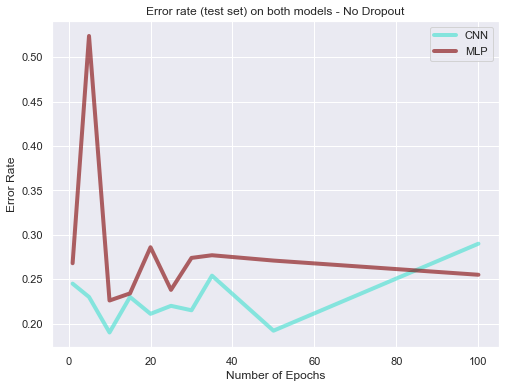

In [14]:
import seaborn as sns
sns.set()

plt.figure(figsize=(8, 6))
plt.title("Error rate (test set) on both models - No Dropout")
plt.xlabel('Number of Epochs')
plt.ylabel('Error Rate')
plt.plot(all_epochs, all_errors_cnn, alpha=0.6, linewidth=4, color='turquoise', label='CNN')
plt.plot(all_epochs, all_errors_mlp, alpha=0.6, linewidth=4, color='maroon', label = 'MLP')
plt.legend(loc='upper right')
plt.show()